In [6]:
import sys
# extending path to be able to import tudaesasII from the parent directory
sys.path.append('../..')

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 5]
matplotlib.rcParams['lines.linewidth'] = 2
import numpy as np
from numpy import pi

from scipy.sparse import coo_matrix, csc_matrix
from scipy.sparse.linalg import inv, eigsh

from pyfe3d.shellprop_utils import isotropic_plate
from pyfe3d import Quad4, Quad4Data, Quad4Probe, INT, DOUBLE, DOF

def mag2db(mag):
    return 20*np.log10(mag)

#NOTE this mesh size might be heavy for your computer
nx = 31
ny = 31

a = 0.4 # [m]
b = 0.4 # [m]

E = 70.e9 # Pa
nu = 0.33
rho = 2.7e3 # kg/m3
h = 0.0002 # m

print(a/nx)

data = Quad4Data()
probe = Quad4Probe()

xtmp = np.linspace(0, a, nx)
ytmp = np.linspace(0, b, ny)
xmesh, ymesh = np.meshgrid(xtmp, ytmp)
ncoords = np.vstack((xmesh.T.flatten(), ymesh.T.flatten(), np.zeros_like(ymesh.T.flatten()))).T

x = ncoords[:, 0]
y = ncoords[:, 1]
z = ncoords[:, 2]
ncoords_flatten = ncoords.flatten()

nids = 1 + np.arange(ncoords.shape[0])
nid_pos = dict(zip(nids, np.arange(len(nids))))
nids_mesh = nids.reshape(nx, ny)
n1s = nids_mesh[:-1, :-1].flatten()
n2s = nids_mesh[1:, :-1].flatten()
n3s = nids_mesh[1:, 1:].flatten()
n4s = nids_mesh[:-1, 1:].flatten()

num_elements = len(n1s)
print('num_elements', num_elements)

KC0r = np.zeros(data.KC0_SPARSE_SIZE*num_elements, dtype=INT)
KC0c = np.zeros(data.KC0_SPARSE_SIZE*num_elements, dtype=INT)
KC0v = np.zeros(data.KC0_SPARSE_SIZE*num_elements, dtype=DOUBLE)
Mr = np.zeros(data.M_SPARSE_SIZE*num_elements, dtype=INT)
Mc = np.zeros(data.M_SPARSE_SIZE*num_elements, dtype=INT)
Mv = np.zeros(data.M_SPARSE_SIZE*num_elements, dtype=DOUBLE)
N = DOF*nx*ny

prop = isotropic_plate(thickness=h, E=E, nu=nu, calc_scf=True, rho=rho)

quads = []
init_k_KC0 = 0
init_k_M = 0
for n1, n2, n3, n4 in zip(n1s, n2s, n3s, n4s):
    pos1 = nid_pos[n1]
    pos2 = nid_pos[n2]
    pos3 = nid_pos[n3]
    pos4 = nid_pos[n4]
    r1 = ncoords[pos1]
    r2 = ncoords[pos2]
    r3 = ncoords[pos3]
    normal = np.cross(r2 - r1, r3 - r2)[2]
    assert normal > 0
    quad = Quad4(probe)
    quad.K6ROT = 1e4
    quad.n1 = n1
    quad.n2 = n2
    quad.n3 = n3
    quad.n4 = n4
    quad.c1 = DOF*nid_pos[n1]
    quad.c2 = DOF*nid_pos[n2]
    quad.c3 = DOF*nid_pos[n3]
    quad.c4 = DOF*nid_pos[n4]
    quad.init_k_KC0 = init_k_KC0
    quad.init_k_M = init_k_M
    quad.update_rotation_matrix(ncoords_flatten)
    quad.update_probe_xe(ncoords_flatten)
    quad.update_KC0(KC0r, KC0c, KC0v, prop)
    quad.update_M(Mr, Mc, Mv, prop, mtype=2) # NOTE lumped matrix
    quads.append(quad)
    init_k_KC0 += data.KC0_SPARSE_SIZE
    init_k_M += data.M_SPARSE_SIZE

print('elements created')

K = coo_matrix((KC0v, (KC0r, KC0c)), shape=(N, N)).tocsc()
M = coo_matrix((Mv, (Mr, Mc)), shape=(N, N)).tocsc()

bk = np.zeros(N, dtype=bool) # constrained DOFs, can be used to prescribe displacements
# eliminating u and v
bk[0::DOF] = True
bk[1::DOF] = True
check = np.isclose(x, a/2) & np.isclose(y, b/2)
bk[2::DOF] = check # zero w
bk[3::DOF] = check # zero rx
bk[4::DOF] = check # zero ry
bk[5::DOF] = check # zero rz

# unknown DOFs
bu = ~bk

# sub-matrices corresponding to unknown DOFs
Kuu = K[bu, :][:, bu]
Muu = M[bu, :][:, bu]
Kuk = K[bu, :][:, bk]
Muk = M[bu, :][:, bk]

L = np.sqrt(M)
Linv = csc_matrix((N, N))
Linv[np.diag_indices(N)] = 1/L[np.diag_indices(N)]
Luu = L[bu, :][:, bu]
Luuinv = Linv[bu, :][:, bu]
Ktilde = Luuinv @ Kuu @ Luuinv.T

rbmodes = 0
Nmodes = 81
print('eig solver begin')
# solves Ax = lambda M x
# we have Ax - lambda M x = 0, with lambda = omegan**2
gamma, Vu = eigsh(A=Kuu, M=Muu, sigma=-1., which='LM', k=Nmodes, tol=1e-9)
Vu = Vu[:, rbmodes:]
gamma = gamma[rbmodes:]

omegan = gamma**0.5

V = np.zeros((N, Nmodes-rbmodes))
V[bu, :] = Vu

P = V
Pu = Vu

print('omegan [rad/s]', omegan)


0.012903225806451613
num_elements 900
elements created
eig solver begin
omegan [rad/s] [   20.90430349    20.90430356    23.30206631    37.47408399
   143.03651254   143.03651256   167.22743231   228.82855097
   419.24219099   419.24219101   477.1761536    575.15476185
   849.49904431   849.49904499   943.47563921   956.80546363
  1082.35995438  1445.05552936  1445.05552968  1574.84481622
  1762.05353856  1912.53131866  1912.53131878  2222.08960539
  2222.08960614  2376.20555195  2634.17894407  2863.99307577
  2863.99568084  3206.39325597  3206.39325614  3266.91734808
  3732.12193855  3782.05694485  3812.22219388  3812.22219403
  4441.95516012  4441.95516033  4754.04107286  4754.05385725
  4801.20122149  5111.78854503  5689.73012371  5689.73012384
  5714.93825187  5714.93825193  6002.66822678  6002.66822682
  6169.54890746  6617.284651    6617.32600335  6868.59380788
  7166.67707173  7536.89400738  7536.89400739  7595.26871553
  8013.98547186  8013.98547192  8447.2975887   8447.4098419

/var/folders/x7/jww7lc053bv10s9m981_324dmy7lhy/T/ipykernel_88673/2086207294.py:129: RuntimeWarning: divide by zero encountered in divide
  Linv[np.diag_indices(N)] = 1/L[np.diag_indices(N)]


Direct Frequency Response Analysis (with base excitation)
===
Damping matrix C calculated from modal damping ratio
---

In [3]:
zeta = 0.01
Dm = np.zeros((Nmodes-rbmodes, Nmodes-rbmodes))
Dm[np.diag_indices_from(Dm)] = 2*zeta*omegan
C = L @ P @ Dm @ P.T @ L.T
Cuu = C[bu, :][:, bu]
Cuk = C[bu, :][:, bk]

Sine sweep analysis
---

In [4]:
amplitude = 0.0001
check = np.isclose(x, a/2) | np.isclose(y, b/2)
u = np.zeros(N)
u[2::DOF] = check*amplitude
uk = u[bk]

displs = []
U = np.zeros(K.shape[0], dtype=np.complex128)
omegas = omegan
for omegaf in omegas:
    dukdt = 1j*omegaf*uk
    d2ukdt2 = -omegaf**2*uk
    Fk = - Muk @ d2ukdt2 - Cuk @ dukdt - Kuk @ uk 
    
    # NOTE Direct FRA
    # 1) Calculate the frequency response matrix
    # Huu = -Muu*omegaf**2 + Cuu*1j*omegaf + Kuu
    # 2) Solve for the displacement frequency response
    # Uu = solve(Huu, Fk)

    # NOTE Modal FRA
    # 1) calculate modal force
    fmodal = Pu.T @ Luuinv @ Fk
    # 2) calculate the analytical FRF
    H = 1/(-omegaf**2 + 2*zeta*1j*omegaf*omegan + omegan**2)
    # 3) calculate the modal frequency response
    r = H*fmodal
    # 4) convert modal into displacement frequency response
    Uu = Luuinv.T @ Pu @ r
   
    U[bu] = Uu
    displs.append(U[2::DOF].copy())
displs = np.asarray(displs)
print(omegan[omegan < omegas.max()])
print('ready')


[  132.48999615   132.48999616   230.33509113   374.43519568
  1015.35812069  1267.13168629  1267.13168629  1518.43094913
  2108.17644521  2108.17644522  2282.39316323  3256.65745144
  3305.74096595  3326.7097476   3954.06645274  3954.06645274
  4759.53101748  4759.53101748  5007.52402507  5735.27351011
  6224.06228214  6224.06228216  6403.98752189  6475.3762133
  6862.30041127  8186.60704428  8186.60704429  8393.62323324
  8457.55461106  8457.55461107  9156.20072313  9962.37055687
 10699.43814878 10782.22740085 10831.27956325 10866.35154232
 10866.35154233 11871.41256186 12270.61792427 12270.61792428
 13347.23201317 13458.4479265  13458.4479265  14103.84760173
 14103.84760174 15019.56169054 15437.85835891 15443.72449408
 16275.85429619 16275.8542962  16473.52442005 16656.51763884
 16905.0945609  17522.47917751 18272.70015198 18788.99936852
 18788.99936853 19179.33027725 20079.79011711 20079.79011712
 20280.93522873 20280.93522874 21743.72674839 21743.7267484
 21759.09120755 22244.1461

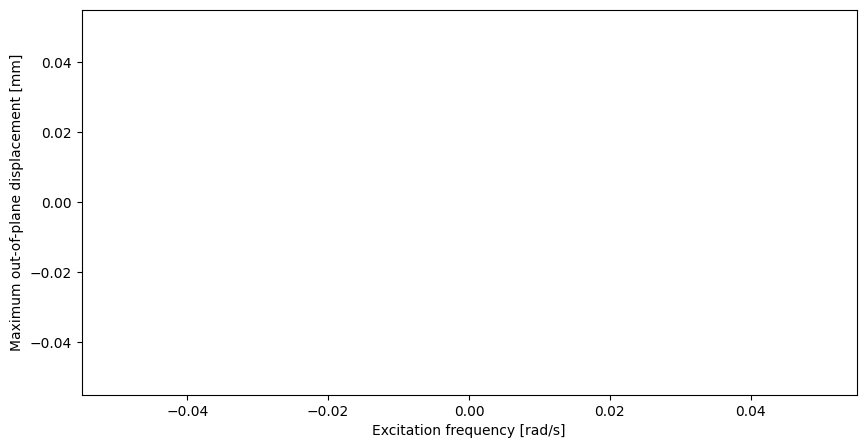

In [38]:
%matplotlib inline
plt.plot(omegas, np.abs(displs).max(axis=1)*1000)
plt.vlines(x=[omegan[omegan < omegas.max()]], ymin=0, ymax=np.abs(displs).max()*1000, ls='--', lw=0.5)
plt.ylabel('Maximum out-of-plane displacement [mm]')
plt.xlabel('Excitation frequency [rad/s]')
plt.show()

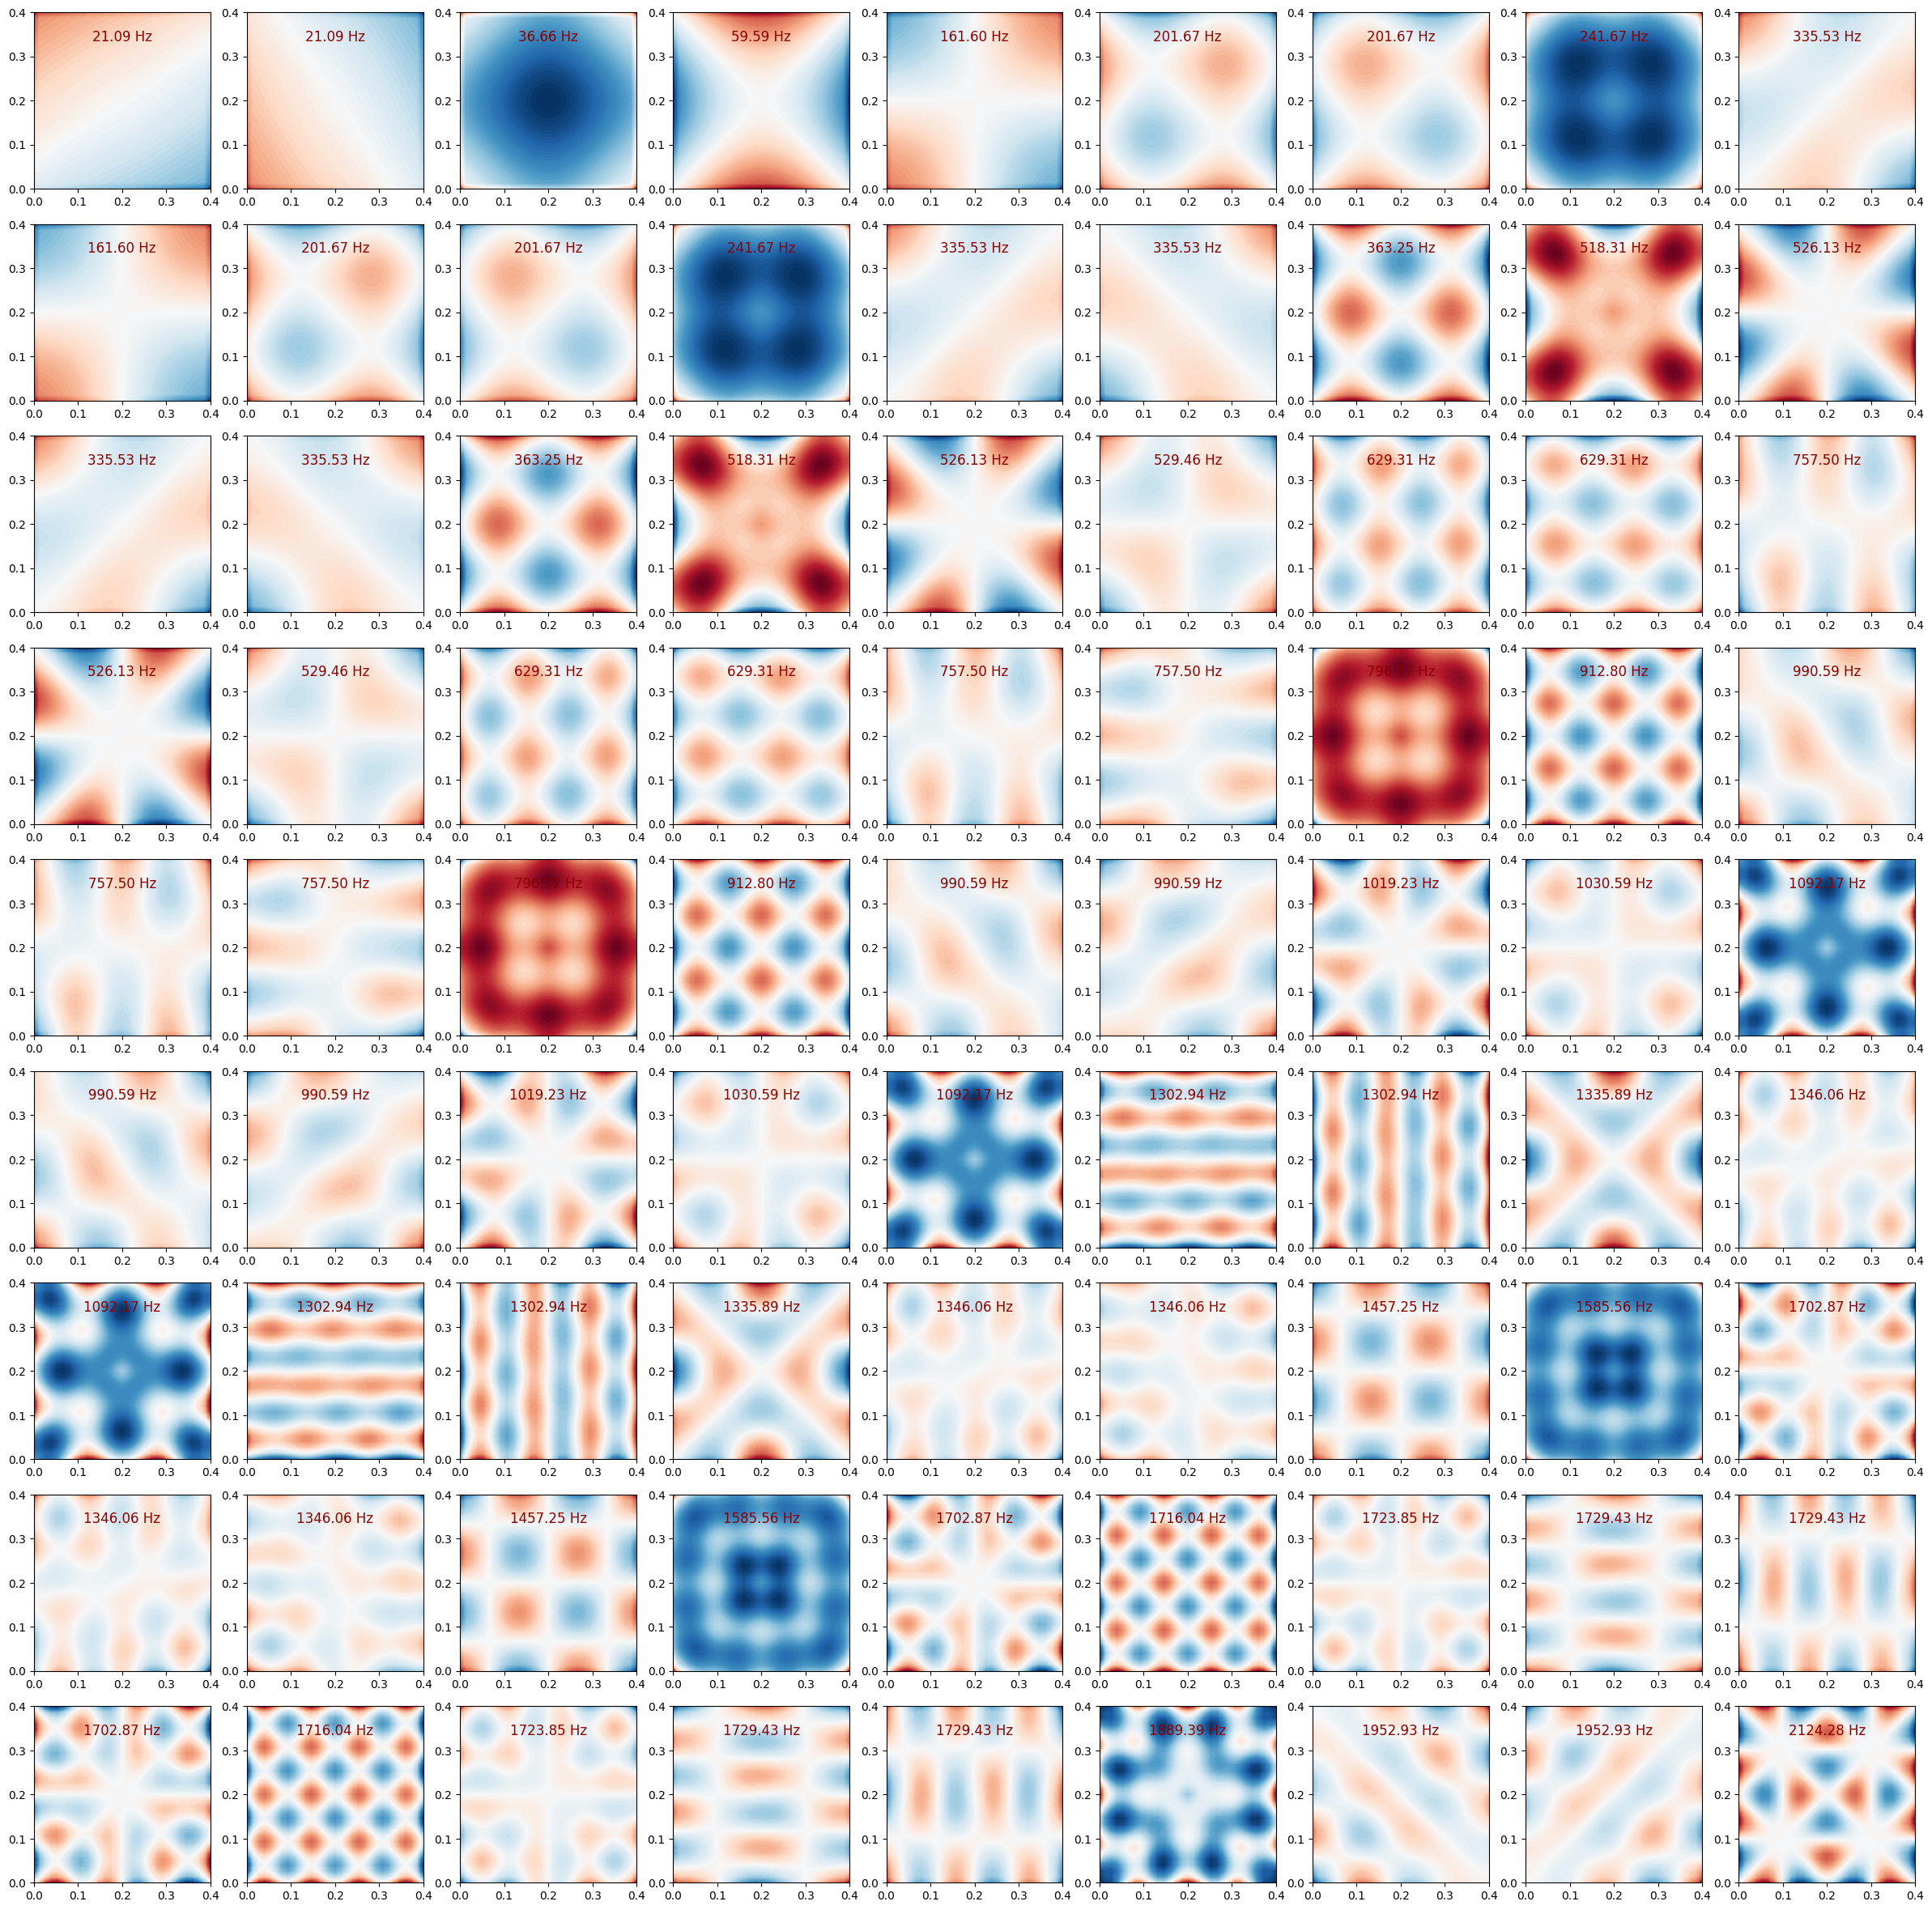

In [5]:
fig, axes = plt.subplots(nrows=9, ncols=9, figsize=[30, 30])
for i in range(9):
    for j in range(9):
        mode = i*4 + j
        Uu = (Luuinv.T @ Vu[:, mode])
        U = np.zeros(K.shape[0])
        U[bu] = Uu
        axes[i, j].contourf(xmesh, ymesh, U[2::DOF].reshape(xmesh.shape).T, levels=100, cmap="RdBu")
        axes[i, j].set_aspect('equal')
        axes[i, j].set_title('%1.2f Hz' % (omegan[mode]/(2*np.pi)), y=0.8, color='darkred')
plt.savefig('mdoffreq06_FRA_modes_pyfe3d.png')

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('wvJAgrUBF4w', start=28, allow_autoplay=True, width=900, height=400)